# Dynamische Systemidentifikation mit CasADi

In [1]:
import casadi as cs
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Gegeben seien Messdaten eines technischen Prozesses mit einem Eingangssignal $u$ und einem Ausgangssignal $y$

In [2]:
data = pkl.load(open('ext_dynamic_data.pkl','rb'))

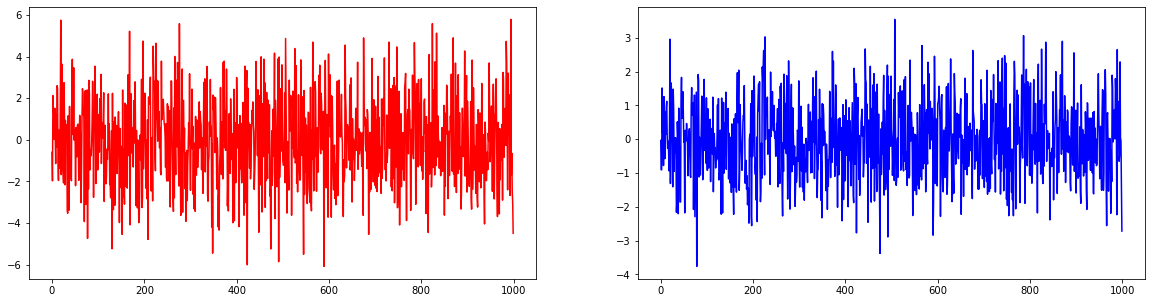

In [3]:
fig,ax = plt.subplots(1,2,figsize=(20,5))
ax[0].plot(data.index,data['u'],'r')
ax[1].plot(data.index,data['y'],'b')

Es ist bekannt, dass es sich um einen dynamischen Prozess 1. Ordnung handelt. Als Modellierungsansatz wird ein lineares ARX-Modell 1. Ordnung gewählt:

$y_{k}=\theta_{1} u_{k-1} + \theta_{2} y_{k-1}$

Da das Modell verschobene Versionen des Ein- und Ausgangssignals als Modelleingangsgröße besitzt, müssen die Daten entsprechend arrangiert werden:

In [4]:
arx_data = np.hstack([data.loc[0:998]['u'].values.reshape(-1,1),
                         data.loc[0:998]['y'].values.reshape(-1,1),
                         data.loc[1:999]['y'].values.reshape(-1,1)])

arx_data = pd.DataFrame(arx_data,columns=['u_k-1','y_k-1','y_k'],index=range(0,999))

In [5]:
print(data)
print(arx_data)

            u         y
0   -0.599218 -0.035277
1   -1.974938 -0.906355
2    2.128959 -0.904214
3    1.302163  1.518063
4    1.284992  0.200684
..        ...       ...
995 -1.705495  2.290396
996 -0.641283  0.044140
997 -2.477823 -0.052656
998 -3.018166 -1.296952
999 -4.497335 -2.719730

[1000 rows x 2 columns]
        u_k-1     y_k-1       y_k
0   -0.599218 -0.035277 -0.906355
1   -1.974938 -0.906355 -0.904214
2    2.128959 -0.904214  1.518063
3    1.302163  1.518063  0.200684
4    1.284992  0.200684  1.055796
..        ...       ...       ...
994  5.795828 -0.470418  2.290396
995 -1.705495  2.290396  0.044140
996 -0.641283  0.044140 -0.052656
997 -2.477823 -0.052656 -1.296952
998 -3.018166 -1.296952 -2.719730

[999 rows x 3 columns]


Plottet man die arrangierten Daten im $u_{k-1}$,$y_{k-1}$,$y_{k}$ Raum, wird der in diesem Fall lineare Zusammenhang ersichtlich:

Text(0.5, 0, 'y_k')

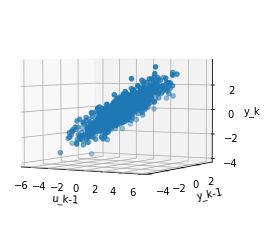

In [6]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.elev = 3 # Höhe der Betrachung
ax.azim = 300 # Neigungswinkel der Betrachtung
ax.scatter(arx_data['u_k-1'],arx_data['y_k-1'],arx_data['y_k'])

ax.set_xlabel('u_k-1')
ax.set_ylabel('y_k-1')
ax.set_zlabel('y_k')

Definition der Modellgleichung als CasADi-Funktion:

In [7]:
theta = cs.MX.sym('theta',2,1)

u = cs.MX.sym('u',2,1)                 # bspw. u[0]='u_k-1','u[1]=y_k-1'

y = theta[0]*u[0] + theta[1]*u[1]

f_model = cs.Function('f_model',[u,theta],[y],['u','theta'],['y'])

Anschließend muss die zu optimierende Funktion als CasADi-Funktion definiert werden. Ziel der Optimierung ist $\boldsymbol{\theta}$ so zu wählen, dass die Summe der Abweichungsquadrate $L = \frac{1}{2}\sum\limits_{k}^{N} (\hat{y}_{k}-y_{k})^2$ minimiert wird:

In [8]:
L = 0
for k in range(0,999):
    u_k = arx_data.loc[k][['u_k-1','y_k-1']].values.reshape((2,1))
    y_k = arx_data.loc[k]['y_k']
    
    y_hat = f_model(u=u_k, theta=theta)['y']
    L = L + 0.5*(y_hat - y_k)**2
    

$L$ is nun ein CasADi-Ausdruck, der die Summe des quadratischen Prädiktionsfehlers in Abhängigkeit der Modellparameter $\boldsymbol{\theta}$ beinhaltet. Eine Abhängigkeit von den Eingangs- oder Ausgangssignalen $u_{1}$, $u_{2}$ und $y$ besteht nicht mehr, da diese bereits "eingesetzt" wurden. 

Die Kostenfunktion ist quadratisch, da der Modellansatz linear in den Parametern $\boldsymbol{\theta}$ ist ($\hat{y}=\sum\limits_{i}^{n}\theta_{i}u_{i}$): 

$\underset{\boldsymbol{\theta}}{\mathrm{minimize}} \qquad \frac{1}{2}\boldsymbol{\theta}^{T}\boldsymbol{H}\boldsymbol{\theta} + \boldsymbol{g}^{T}\boldsymbol{\theta}$


Das bedeutet die Lösung des Optimierungsproblems ist eindeutig (globales Optimum) und kann in einem einzigen Schritt ermittelt werden.

Casadi stellt ein Interface für quadratische Solver bereit: "qpsol" 

In [9]:
qp = {'x':theta, 'f':L}
S = cs.qpsol('S', 'qpoases', qp)

Der Solver wird gestartet, indem die Solver-Funktion aufgerufen wird:

In [10]:
r=S()
theta_opt = r['x']



#################   qpOASES  --  QP NO.   1   ##################

    Iter   |    StepLength    |       Info       |   nFX    
 ----------+------------------+------------------+--------- 
       0   |   0.000000e+000   |   REM BND    0   |     1   
       1   |   3.872143e-010   |   REM BND    1   |     0   
       2   |   1.000000e+000   |    QP SOLVED     |     0   


Die optimalen Parameter sind dann

In [11]:
theta_opt

DM([0.501663, 0.107863])

Auswertung des Modells mit den optimierten Parametern auf den Trainingsdaten:

In [12]:
y_hat = []
for k in range(0,999):
    u_k = arx_data.loc[k][['u_k-1','y_k-1']].values.reshape((2,1))
    y_k = arx_data.loc[k]['y_k']
    
    y_hat.append(float(f_model(u=u_k, theta=theta_opt)['y']))

arx_data = arx_data.assign(y_hat=y_hat)

Auswertung des Modells mit den optimalen Parametern auf den Messdaten

Text(0.5, 0, 'y')

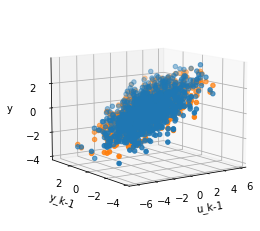

In [13]:
ax.scatter(arx_data['u_k-1'],arx_data['y_k-1'],arx_data['y_hat'])
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.elev = 10 # Höhe der Betrachung
ax.azim = 235 # Neigungswinkel der Betrachtung
ax.scatter(arx_data['u_k-1'],arx_data['y_k-1'],arx_data['y_k'])
ax.scatter(arx_data['u_k-1'],arx_data['y_k-1'],arx_data['y_hat'])

ax.set_xlabel('u_k-1')
ax.set_ylabel('y_k-1')
ax.set_zlabel('y')